In [1]:
import os
from glob import glob

def get_file_names(path):
    file_names = glob(os.path.join(path, *['*'] * 3, '*.jpg'))
    return file_names

def convert_to_image_ids(fnames):
    image_ids = []
    for fname in fnames:
        image_id = os.path.splitext(os.path.basename(fname))[0]
        image_ids.append(image_id)
    return image_ids

def get_image_ids(path):
    file_names = get_file_names(path)
    image_ids = convert_to_image_ids(file_names)
    return image_ids    

In [2]:
import csv
import numpy as np
from dataclasses import dataclass
from typing import List

@dataclass
class RetrievalResult:
    test_id: str
    chosen_ids: List[str]


def generate_random_results(test_ids, index_ids):
    for test_id in test_ids:
        chosen_ids = np.random.choice(index_ids, 100, replace=False)
        yield RetrievalResult(
            test_id = test_id,
            chosen_ids = chosen_ids
        )

def write_submission(output_fname, results: List[RetrievalResult]):
    with open(output_fname, 'w') as f:
        writer = csv.DictWriter(f, fieldnames=('id', 'images'))
        writer.writeheader()
        for result in results:
            writer.writerow(
                {
                    'id': result.test_id,
                    'images':' '.join(result.chosen_ids)
                }
            )

In [3]:
from pathlib import Path

home_path = Path('/root/kaggle/google-retrieval')
data_path = Path('/shared/lorenzo/data-gld')
index_path = data_path/'index'
test_path = data_path/'test'

index_files = get_file_names(index_path)
test_files = get_file_names(test_path)

index_ids = get_image_ids(index_path)
test_ids = get_image_ids(test_path)

In [4]:
import pandas as pd
temp = pd.read_csv(data_path/'sample_submission.csv')
temp.head()

,id,images
0,00084cdf8f600d00,39ff080e3b9e37d9
1,00141b8a5a729084,d75e248790c371d4 a0a13eb5924b395c 49dac2cf6777...
2,0044d82ea7654ece,80f1aba556c3de4e
3,00d5b448fa93e1b8,2c6f6cbaa3f586c6
4,012436be7f659057,NaN


In [34]:
class GLDConfig:
    debug = len(temp) == 1129
    pretrained_path = home_path/'weight/resnet50-epoch=23-fold0-val_loss=3.8455.ckpt'
    thres = 0.5

    num_workers = 8

    backbone_name = "resnet50"
    gd_config = 'SG'
    feature_dim = 1536
    global_only = True
    random_gamma_rescale = False
    reduced_dim = 128

    data_root = data_path
    img_size = 224
    img_scales = [1.0]
    num_classes = 81313

    batch_size = 1

    top_k = 100

    lr = 1e-4
    smoothing : 0.1
    temperature : 0.5
    margin : 0.1

    weight_path = '/root/kaggle/google-retrieval/pl_output/resnet50-epoch=23-fold0-val_loss=3.8455.ckpt'
    output_dir = '/root/kaggle/google-retrieval/weight'
    smoothing = 0.1
    temperature = 0.5
    margin = 0.1

    device = 'cuda:2'

In [6]:
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.geometric.resize import SmallestMaxSize
from scipy import spatial
from tqdm.auto import tqdm
from torchvision.datasets.folder import default_loader
from torch.utils.data import DataLoader
from torch.nn import Parameter

import glob
import math
import os
import timm
import torch

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets

from dataset import GLDataset
from module.cgd import CGD
from model.cgd import LitCGD

In [23]:
model = CGD(GLDConfig.backbone_name, GLDConfig.gd_config, GLDConfig.feature_dim, GLDConfig.num_classes)
model.load_state_dict(torch.load(GLDConfig.pretrained_path), strict=False)
model.to(GLDConfig.device)
model.eval()

CGD(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [24]:
transform = A.Compose([
                A.CenterCrop(GLDConfig.img_size, GLDConfig.img_size),
                A.Normalize(),
                ToTensorV2(p=1.0),
])
dataset = GLDataset(root=GLDConfig.data_root, split_df_root=None, split='index', transform=transform)

In [27]:
img, _ = dataset[2]
img = img.unsqueeze(0).to(GLDConfig.device)

feature, classes = model(img)

In [31]:
feature.shape

torch.Size([1, 1536])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


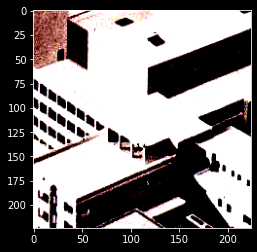

In [32]:
plt.imshow(img.squeeze(0).cpu().permute(1,2,0))

In [35]:
index_features_scaled = []
for scale in GLDConfig.img_scales:
    transform = A.Compose([
                A.CenterCrop(GLDConfig.img_size, GLDConfig.img_size),
                A.Normalize(),
                ToTensorV2(p=1.0),
    ])
    dataset = GLDataset(root=GLDConfig.data_root, split_df_root=None, split='index', transform=transform)
    dataloader = DataLoader(dataset, batch_size=GLDConfig.batch_size, pin_memory=True, num_workers=GLDConfig.num_workers)

    index_ids = []
    index_features = []
    for idx, (inputs, ids) in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs = inputs.to(GLDConfig.device)

        index_ids += ids
        features_g, _ = model(inputs)
        index_features.append(features_g.cpu().detach().numpy())

        if GLDConfig.debug:
            if idx==10:
                break

    index_features = np.concatenate(index_features)
    index_features_scaled.append(index_features)
index_features = np.mean(index_features_scaled, axis=0)
index_features /= np.linalg.norm(index_features, 2, axis=1, keepdims=True)

  0%|          | 0/76176 [00:00<?, ?it/s]

In [42]:
test_features_scaled = []
for scale in GLDConfig.img_scales:
    transform = A.Compose([
                A.CenterCrop(GLDConfig.img_size, GLDConfig.img_size),
                A.Normalize(),
                ToTensorV2(p=1.0),
    ])
    dataset = GLDataset(root=GLDConfig.data_root, split_df_root=None, split="test", transform=transform)
    dataloader = DataLoader(dataset, batch_size=GLDConfig.batch_size, pin_memory=True, num_workers=GLDConfig.num_workers)

    test_ids = []
    test_features = []
    for idx, (inputs, ids) in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs = inputs.to(GLDConfig.device)

        test_ids += ids
        features_g, _ = model(inputs)
        test_features.append(features_g.cpu().detach().numpy())
        
        if GLDConfig.debug:
            if idx == 10:
                break
    test_features = np.concatenate(test_features)
    test_features_scaled.append(test_features)
test_features = np.mean(test_features_scaled, axis=0)
test_features /= np.linalg.norm(test_features, 2, axis=1, keepdims=True)

  0%|          | 0/1129 [00:00<?, ?it/s]

In [43]:
TOP_K = min(100, len(index_ids)-1)
    
import time

from contextlib import contextmanager


@contextmanager
def timer(name):
    t0 = time.time()
    print(f"[{name}]")
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def get_predictions(test_ids, test_embeddings, train_ids, train_embeddings):
    PredictionString_list = []
    with timer("Matching..."):
        for test_index in range(test_embeddings.shape[0]):
            distances = spatial.distance.cdist(test_embeddings[np.newaxis, test_index, :], train_embeddings, 'cosine')[0]
            partition = np.argpartition(distances, TOP_K)[:TOP_K]
            nearest = sorted([(train_ids[p], distances[p]) for p in partition], key=lambda x: x[1])
            pred_str = ""
            for train_id, cosine_distance in nearest:
                pred_str += train_id
                pred_str += " "
            PredictionString_list.append(pred_str)

    return test_ids, PredictionString_list

In [44]:
test_ids, PredictionString_list = get_predictions(test_ids, test_features, index_ids, index_features)
sub_df = pd.DataFrame(zip(test_ids, PredictionString_list)).rename(columns={0: "id", 1: "images"})

[Matching...]
[Matching...] done in 0 s


In [45]:
sub_df

,id,images
0,5f5a7b3e3f2c17ca,fc908d2ae937d315 fc9e96b95d658f90 fc91c90f295e...
1,5f27abd2ea15f147,fc91f3e31330a15c fc908d2ae937d315 fc9e96b95d65...
2,5f6238137076d11b,fc9d1a06c8dafc06 fc91f3e31330a15c fc9197661640...
3,5ffd474f62502596,fc908d2ae937d315 fc9acaf4bf8a0a03 fc91f3e31330...
4,5f14c1bbc07f34e6,fc91f3e31330a15c fc91976616408547 fc908d2ae937...
5,5f1c08a01ec523d1,fc91f3e31330a15c fc908d2ae937d315 fc9e96b95d65...
6,5fc41fa23cda8d6f,fc91f3e31330a15c fc908d2ae937d315 fc9197661640...
7,5fc68cb1c569dfa2,fc91f3e31330a15c fc91c90f295ebbb8 fc95d5aa5230...
8,56aaed126d7cb956,fc908d2ae937d315 fc9acaf4bf8a0a03 fc91f3e31330...
9,56d525bfd1da5e15,fc91f3e31330a15c fc908d2ae937d315 fc9197661640...


In [47]:
temp

,id,images
0,00084cdf8f600d00,39ff080e3b9e37d9
1,00141b8a5a729084,d75e248790c371d4 a0a13eb5924b395c 49dac2cf6777...
2,0044d82ea7654ece,80f1aba556c3de4e
3,00d5b448fa93e1b8,2c6f6cbaa3f586c6
4,012436be7f659057,NaN
...,...,...
1124,ff06f084134f4df6,acd395de725c6ffa 0adc1ff5ed5df4b5 4b57b48ac2b7...
1125,ff4135c3071f7b36,216d1bea7a259232 067a42c02294ce2c
1126,ff8b519e7dfc5506,59ca927b6e0c8a7a 452a2125ea39a713
1127,ffb08958f4e67f61,b6b5c29be4dd342d


In [46]:
df = pd.read_csv("../input/landmark-retrieval-2021/sample_submission.csv")
df.pop("images")
df = pd.merge(df, sub_df, how="left", on="id")
df.to_csv("submission.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../input/landmark-retrieval-2021/sample_submission.csv'